### Colored Inversion

Inversion converts reflectivity data to physical properties of the earth, such as acoustic impedance (AI),
the product of seismic velocity and bulk density. This is crucial because, while reflectivity informs us about boundaries, impedance can be converted to useful earth properties such as porosity and fluid content via known petrophysical relationships.

In [51]:
import numpy as np                         # For array based computations and world domination
import matplotlib.pyplot as plt
from scipy import signal
from scipy import optimize

In [52]:
data = np.loadtxt('AI', skiprows=30)
time = data[:, 0]                           # Time
AI = data[:, 1]                             # Acoustic Impedance
trace = np.loadtxt('trace', skiprows=7)     # Seismic traces
trace = trace[:, 1]
sr = 4                                      # Sampling rate

In [53]:
fmin = 10                                   # minimum frequency
fmax = 70                                   # maximum frequency
L = 200                                     # sample number of operator length
sm = 25                                     # frequency smoother (Hz)

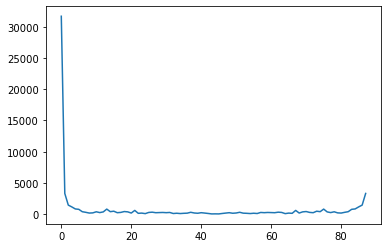

In [55]:
n_log = AI.shape[0]
spec_log = np.fft.fft(AI) / n_log

plt.plot(np.abs(spec_log))
plt.show()

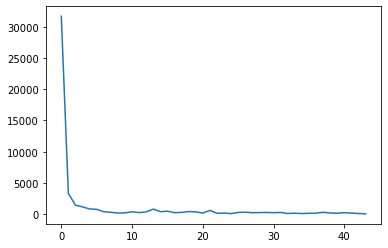

In [56]:
spec_log = spec_log[range(n_log//2)]

plt.plot(np.abs(spec_log))
plt.show()

##### Spectrum Model

<ipython-input-58-421c4992b222>:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq_log), np.log10(abs(spec_log)), '.')


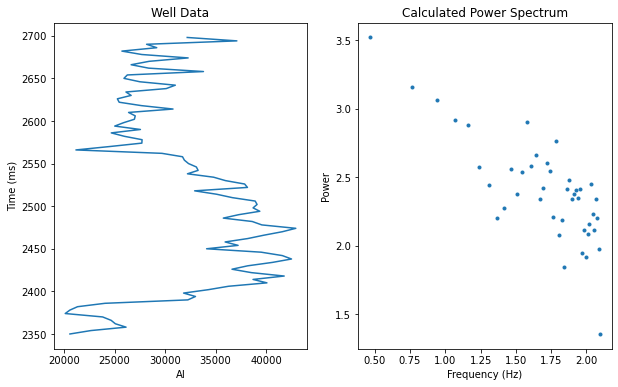

In [58]:
freq_log = np.linspace(0, 1, len(spec_log))*1000/(2*sr)

plt.figure(num=None, figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(AI, time)
plt.xlabel('AI')
plt.ylabel('Time (ms)')
plt.title('Well Data')

plt.subplot(1,2,2)
plt.plot(np.log10(freq_log), np.log10(abs(spec_log)), '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Calculated Power Spectrum')
plt.show()

##### Operator Inversion

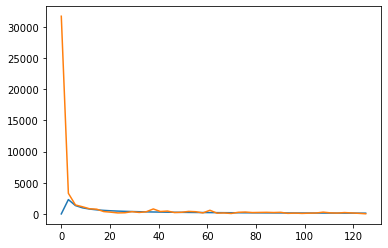

In [59]:
def linearize(p, x):
    return p[0] * x**p[1]

def error(p, x, y):
    return np.log10(y) - np.log10(linearize(p, x))

args = (freq_log[1:None], np.abs(spec_log[1:None]))
qout, success = optimize.leastsq(error, (3.5, -0.8), args=args, maxfev=3000)

spec_log_model = np.zeros((freq_log.shape))
spec_log_model[1:None] = freq_log[1:None]**qout[1]*qout[0]
plt.plot(freq_log, spec_log_model)
plt.plot(freq_log, abs(spec_log))
plt.show()

<ipython-input-60-14bdbb2cf376>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nsm = np.int(sm/freq_log[1])
<ipython-input-60-14bdbb2cf376>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more de

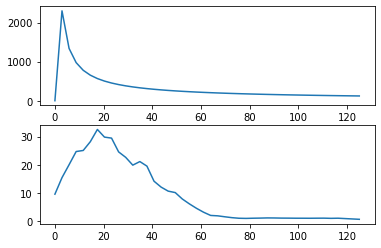

In [60]:
trace = trace - np.mean(trace)
Nsm = np.int(sm/freq_log[1])
wf = np.abs(np.fft.fft(trace))
wf = wf[0:np.int(np.round(len(wf)/2))]
wfs = np.convolve(wf, np.ones(Nsm)/Nsm, 'same')

plt.subplot(2,1,1)
plt.plot(freq_log,spec_log_model)
plt.subplot(2,1,2)
plt.plot(freq_log, wfs)
plt.show()

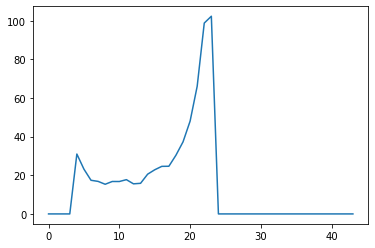

In [61]:
n1 = np.min(np.where(freq_log >= fmin))
n2 = np.max(np.where(freq_log <= fmax))

# Cara 1
Ff = np.zeros_like(spec_log_model)
Ff[n1:n2] = spec_log_model[n1:n2]/(wfs[n1:n2] + 10**(-2))

plt.plot(Ff)
plt.show()

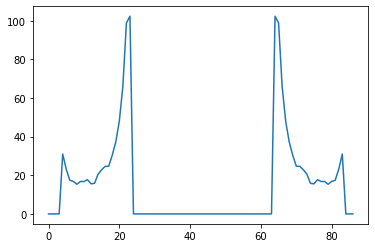

In [62]:
Ff = np.hstack((Ff, np.flipud(Ff[1:len(Ff)])))
plt.plot(Ff)
plt.show()

<ipython-input-63-00b1b7586376>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ft = np.hstack((Ft[np.int(np.round(len(Ft)/2)+1):len(Ft)], Ft[0:np.int(np.round(len(Ft)/2)+1)]))


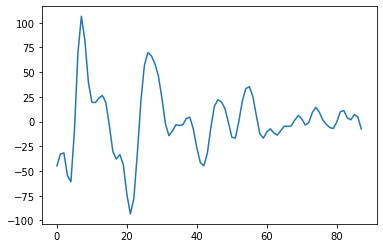

In [63]:
Ft = np.real(np.fft.ifft(Ff))
Ft = np.hstack((Ft[np.int(np.round(len(Ft)/2)+1):len(Ft)], Ft[0:np.int(np.round(len(Ft)/2)+1)]))
#Ft = np.imag(signal.hilbert(Ft))

Rel_Imp = np.convolve(trace, Ft, mode='same')

plt.plot(Rel_Imp)
plt.show()

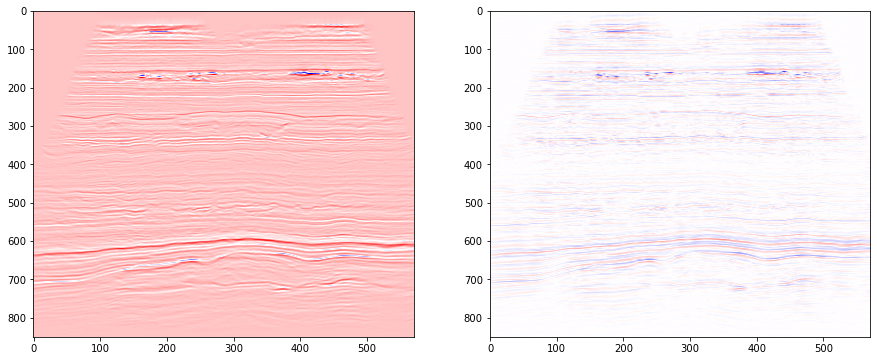

In [64]:
traces = np.loadtxt('volve_arb_PGC.txt')

relimp = np.zeros_like(traces)
for i in np.arange(0, traces.shape[1], 1):
    relimp[:, i] = np.convolve(traces[:, i], Ft, 'same')

ampmax = np.max(abs(relimp))

plt.figure(num=None, figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(traces, cmap='seismic', aspect='auto', interpolation='bilinear')
plt.subplot(1,2,2)
plt.imshow(relimp, cmap='seismic', aspect='auto', vmin= -ampmax, vmax=ampmax, interpolation='bilinear')
plt.show()